In [1]:
import gc
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import datetime as dt
import keras.backend as K
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Model
from keras.layers import Input, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, \
                confusion_matrix, classification_report

# custom Fuzzy Layers
from sofenn import SOFNN
from sofenn.layers import FuzzyLayer, NormalizedLayer, WeightedLayer, OutputLayer

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('../data/FinalDataset.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1763 entries, 12/27/13 to 10/24/18
Columns: 132 entries, com_count to bitcoin_market_cap
dtypes: float64(64), int64(68)
memory usage: 1.8+ MB


In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,bitcoin_open,bitcoin_high,bitcoin_low,bitcoin_close,bitcoin_volume,bitcoin_market_cap
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12/27/13,6065,477,1516,766,666,253,105,74,14,6,67,10,22,4,151,15,1,96.25,0.584285,4.434285,14,3,0,13.0,0.075103,0.595103,1,0,0,1.75,0.000659,0.070659,9,1,0,4.25,0.025917,0.195917,1,0,0,0.75,0.000924,0.030924,0,5,0.092715,0.006623,0.059603,0.006623,151,15,1,96.25,0.584285,4.434285,36,2,0,21.00,0.107567,0.947567,27,1,0,14.00,0.072764,0.632764,2,0,0,2.75,0.00

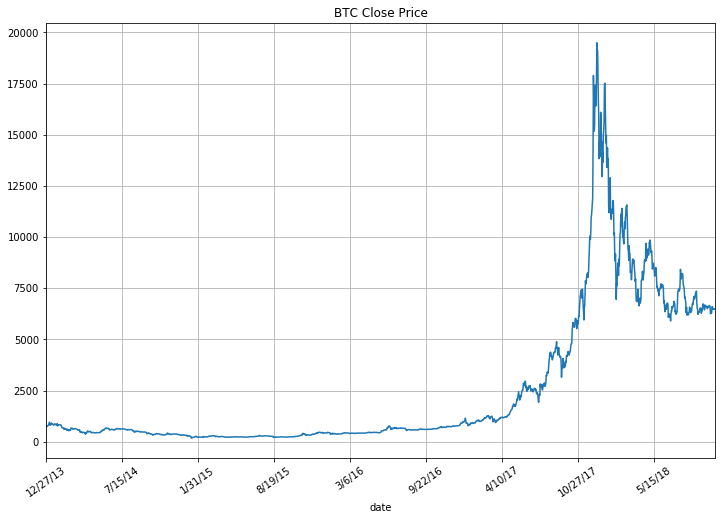

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35, figsize=(12,8))

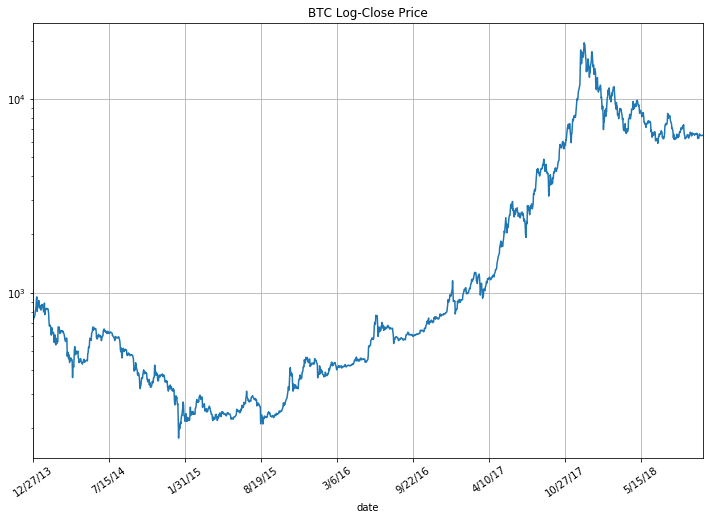

In [5]:
# show log-closing price time series
df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35, figsize=(12,8))

In [6]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  1763.0
number of months:  58.8
number of years:    4.8


# Defining Functions

## Loading and Preparing Data

In [7]:
# function to read in dataset

def get_data():
    return pd.read_csv('../data/FinalDataset.csv',index_col='date')

In [8]:
# function to drop unneeded fields

def keep_only_close(df_in):
    drops = ['bitcoin_open', 'bitcoin_high', 'bitcoin_low',
             'bitcoin_volume', 'bitcoin_market_cap']
    return df_in.drop(drops, axis=1) 

In [9]:
# function to add predicted column for tomorrow's close price

def add_prediction_field(df_in):
    # creating predicted value
    # create column to hold tomorrow's close for each day
    df_in['tomorrow_close'] = df_in['bitcoin_close'].shift(-1)
    # change in price between consecutive closing days
    df_in['day_change'] = df_in['tomorrow_close'] - df_in['bitcoin_close']
    # indicator variable to be used for predicting higher/lower days
    df_in['y'] = np.where(df_in['day_change'] >= 0, 1, 0)
        
    # drop intermediate columns
    return df_in.drop(['tomorrow_close', 'day_change'], axis=1)

In [10]:
# function to retrieve lag values to use for each feature

def get_feature_lag_dict(lag_vers=1):
    # check value of input
    if lag_vers not in [1, 2, 3, 4]:
        raise ValueError('Incorrect Version')
    
    # read in right version of file
    df = pd.read_csv('../lags/optimal_v{}.csv'.format(lag_vers))
    
    # return dictionary of features as keys and lags as values
    return dict(zip(df.feature, df.lags))

In [11]:
# function to add lags for daily features

def add_lags(df_in, lag_vers=1):
    # splitting into X/y for separate processing
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    # save list of columns for lags
    col_list = X.columns
    # create output DF
    df_out = X.copy()
    
    # creating lags
    f_dict = get_feature_lag_dict(lag_vers=lag_vers)
    # create lag columns for each other variable
    for col in col_list:
        if col not in f_dict.keys(): continue
        for lag in range(int(f_dict[col])):
            df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)

    # return and drop na
    df_out['y'] = y
    return df_out.dropna()

In [12]:
# function to remove data before certain date

def truncate_date(df_in, first_day='1999-1-1'):
    # set mask of Bool values
    mask = (pd.to_datetime(df_in.index) >= first_day)
    return df_in.loc[mask]

In [13]:
# function to rejoin training data into X/y again

def rejoin_training_data(X_train, X_test, y_train, y_test):
    Xs = [X_train, X_test]
    Ys = [y_train, y_test]
    
    df_out = pd.concat(Xs)
    df_out['y'] = pd.concat(Ys)
    
    return df_out

In [14]:
# function to create train/test X and y
def create_training_data(df_in, lag_vers=1, train_split=0.7, rescale=True, k_feat_perc=None):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train.values)
        cols = X.columns
        X_train = pd.DataFrame(scaler.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(scaler.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # select top K features to use
    if k_feat_perc:
        selector = SelectPercentile(chi2, percentile=k_feat_perc).fit(
                                    X_train.values,y_train.values)
        # index and names of remainig columns after filter
        cols = X_train.columns[selector.get_support(indices = True)]
        X_train = pd.DataFrame(selector.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(selector.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # recreate into X/y DF and add lags
    df_renew = rejoin_training_data(X_train, X_test, y_train, y_test)
    df_renew = add_lags(df_renew, lag_vers=lag_vers)
    
    # split into test train again
    X, y = df_renew[df_renew.columns[:-1]], df_renew[df_renew.columns[-1]]
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]

    # display shapes
    print('='*65)
    print('New Training Set')
    print('Training Set Dims: {}'.format(X_train.shape))
    print('Testing Set Dims:  {}'.format(X_test.shape))
    print('='*65)

    return X_train, X_test, y_train, y_test

In [15]:
# function to prep data and return DF for modeling

def prepare_data(lag_vers=1, train_split=0.7, close_o=False, 
                         first_day=None, rescale=True, k_feat_perc=None):
    # read in  dataset and initialize output df
    df_in = get_data()
    
    # drop non-price fields if needed
    if close_o:
        df_in = keep_only_close(df_in)
    
    # add prediction field
    df_in = add_prediction_field(df_in)
    
    # cut off prior to first_day
    if first_day:
        df_in = truncate_date(df_in, first_day)
    
    return create_training_data(df_in, lag_vers=lag_vers, train_split=train_split, 
                                rescale=rescale, k_feat_perc=k_feat_perc)

## Preparing Data for Training

In [16]:
# split dataset
X_train, X_test, y_train, y_test = prepare_data(lag_vers=2, train_split=0.9, close_o=False, 
                                    first_day='2016-7-1', rescale=True, k_feat_perc=25)

New Training Set
Training Set Dims: (749, 149)
Testing Set Dims:  (84, 149)


In [17]:
X_train.shape

(749, 149)

In [18]:
X_test.shape

(84, 149)

In [19]:
y_train.shape

(749,)

In [20]:
y_test.shape

(84,)

In [21]:
# balance of dependent variable values
ones = y_train.sum()
zeros = y_train.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 316
1's: 433


In [22]:
# balance of dependent variable values
ones = y_test.sum()
zeros = y_test.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 43
1's: 41


## Build, Train, Test SOFNN Model

In [23]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=5)

Building SOFNN with 5 neurons
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 149)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            1490        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            750         Inputs[0][0]                     
       

In [24]:
sofnn._train_model()
y_pred = sofnn._evaluate_model()

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
749/749 [==============================] - 2s 3ms/step - loss: 0.6894 - acc: 0.5714 - mean_absolute_percentage_error: 225634025.8692
Epoch 2/50
749/749 [==============================] - 0s 141us/step - loss: 0.6820 - acc: 0.5781 - mean_absolute_percentage_error: 235918093.5861
Epoch 3/50
749/749 [==============================] - 0s 138us/step - loss: 0.6796 - acc: 0.5781 - mean_absolute_percentage_error: 236905637.3405
Epoch 4/50
749/749 [==============================] - 0s 137us/step - loss: 0.6780 - acc: 0.5781 - mean_absolute_percentage_error: 236983138.3071
Epoch 5/50
749/749 [==============================] - 0s 156us/step - loss: 0.6767 - acc: 0.5781 - mean_absolute_percentage_error: 237332798.7183
Epoch 6/50
749/749 [==============================] - 0s 159us/step - loss: 0.6756 - acc: 0.5794 - mean_absolute_percentage_error: 237632114.6702
Epoch 7/50
749/749 [==============================] - 0s 147us/step - loss: 0.

## Plot Prediction Results

In [25]:
# plot results

def plot_results():
    # plotting results
    df_plot = pd.DataFrame()

    # create pred/true time series
    df_plot['price'] = df['bitcoin_close'][-84:]
    df_plot['pred'] = y_pred * df_plot['price']
    df_plot['true'] = y_test * df_plot['price']
    df_plot['hits'] = df_plot['price'] * (df_plot['pred'] == df_plot['true'])
    df_plot['miss'] = df_plot['price'] * (df_plot['pred'] != df_plot['true'])

    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(df_plot['price'], color='b')
    plt.bar(df_plot['price'].index, df_plot['hits'], color='g')
    plt.bar(df_plot['price'].index, df_plot['miss'], color='r')
    for label in ax.xaxis.get_ticklabels()[::400]:
        label.set_visible(False)

    plt.title('BTC Close Price Against Predictions')
    plt.xlabel('Dates')
    plt.ylabel('BTC Price ($)')
    plt.grid(True)
    plt.xticks(df_plot['price'].index[::4], 
               df_plot['price'].index[::4], rotation=70)
    plt.show()

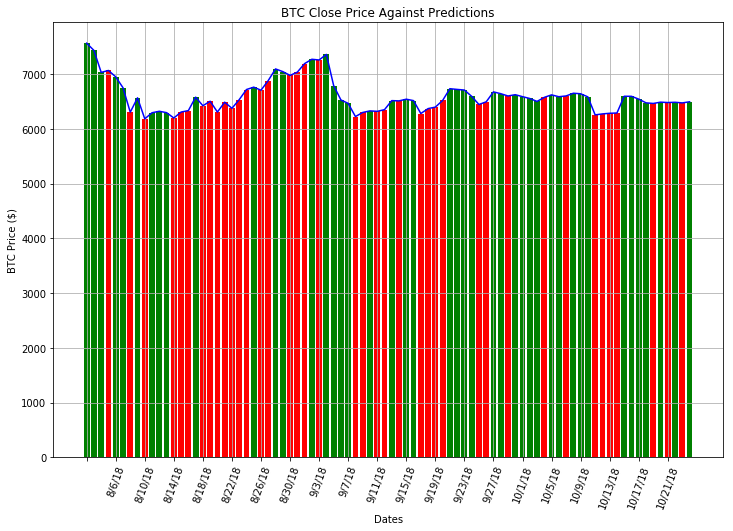

In [26]:
plot_results()

In [27]:
# function to create and train model

def run_model(rules=5, batch_size = 1, epochs=5):
    # get shape of training data
    samples, feats = X_train.shape
    
    # add layers
    inputs = Input(name='Inputs',shape=(feats,))
    fuzz = FuzzyLayer(rules)
    norm = NormalizedLayer(rules)
    weights = WeightedLayer(rules)
    raw = OutputLayer()
    
    # run through layers
    phi = fuzz(inputs)
    psi = norm(phi)
    f = weights([inputs, psi])
    raw_output = raw(f)
    #raw_output = Dense(1, name='RawOutput', activation='linear', use_bias=False)(f)
    preds = Activation(name='OutputActivation', activation='sigmoid')(raw_output)
    
    # compile model and output summary 
    model = Model(inputs=inputs, outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    # fit model and evaluate
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1] * 100
    print("\nAccuracy: {:.2f}%".format(accuracy))
    
    # print confusion matrix
    print('\nConfusion Matrix')
    print('='*20)
    y_pred = np.squeeze(np.where(model.predict(X_test) >= 0.5, 1, 0), axis=-1)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                       index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes']))
    
    # print classification report
    print('\nClasification Report')
    print('='*20)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    
    return model, y_pred

In [28]:
# test out various nodes
for rule in [5]:
    print('{} Rules'.format(rule))
    model, y_pred = run_model(rules=rule, batch_size=30, epochs=50)

5 Rules
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 149)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            1490        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            750         Inputs[0][0]                     
                                                                 Normalization[0][0]              
__

## Testing Model Attributes

In [29]:
for layer in model.layers:
    print(layer.name, layer.get_weights())

Inputs []
FuzzyRules [array([[ 1.11037113e-01, -1.69366598e-01, -1.86161429e-03,
        -2.46987287e-02, -4.36976030e-02],
       [ 1.44344687e-01, -1.70439750e-01, -8.46349224e-02,
         8.58081970e-03, -1.11175902e-01],
       [-1.02289729e-02, -1.77676156e-01,  5.47848456e-02,
        -2.08420325e-02, -1.01923265e-01],
       [ 7.42721260e-02, -1.59736097e-01,  1.64388809e-02,
         5.56950308e-02, -8.73984694e-02],
       [ 1.07378840e-01, -2.05401093e-01, -1.16341203e-01,
        -5.81689700e-02, -1.00866660e-01],
       [ 4.31686640e-02, -1.43760473e-01, -1.93878058e-02,
        -4.48253378e-02, -5.12003042e-02],
       [ 8.17819610e-02, -1.16465867e-01,  3.00379228e-02,
        -1.64172888e-01, -2.06162006e-01],
       [ 6.14325851e-02, -9.58862826e-02,  2.79479269e-02,
        -8.15959796e-02, -9.11395177e-02],
       [ 8.56815130e-02, -1.43529177e-01, -7.00353831e-02,
        -4.82881777e-02, -9.91637334e-02],
       [ 1.98718626e-02, -1.35355383e-01,  5.05595393e-02,
 

In [30]:
layer_name = 'Weights'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train)

In [31]:
intermediate_output

array([[ 1.5118929e+00,  1.5236560e-03, -9.5306838e-01,  2.1004448e-02,
         9.4779423e-03],
       [ 1.2040688e+00,  2.3051505e-03, -9.8896992e-01,  3.5720561e-02,
         9.8993229e-03],
       [ 1.0931607e+00,  3.0381503e-03, -9.0537107e-01,  3.2211386e-02,
         9.8427283e-03],
       ...,
       [ 1.1593702e+00,  2.9074828e-04, -2.2052279e+00,  4.8357587e-02,
         9.4996963e-04],
       [ 1.2414138e+00,  3.5664832e-04, -2.2971816e+00,  4.7881495e-02,
         8.6879323e-04],
       [ 1.3677280e-01,  1.8575265e-05, -4.0823770e+00,  6.7325500e-03,
         8.4144340e-05]], dtype=float32)

In [32]:
for layer in model.layers[1:]:
    print(layer.name, '\nInput Shape', layer.input_shape,'\nOutput Shape', layer.output_shape, '\n', 
          '\nTest Shape', sofnn._get_layer_output(layer.name).shape,'\n', sofnn._get_layer_output(layer.name))

FuzzyRules 
Input Shape (None, 149) 
Output Shape (None, 5) 
 
Test Shape (84, 5) 
 [[7.37045258e-10 1.26655986e-09 5.31106252e-08 1.60280414e-10
  1.96465010e-07]
 [1.77700667e-11 4.53315233e-11 1.02242748e-09 2.09025600e-13
  1.81351589e-09]
 [9.25009136e-09 2.77033507e-08 3.34674723e-07 7.54994511e-10
  5.27333093e-08]
 [7.20311959e-07 1.26948828e-06 1.18516627e-05 2.11286064e-08
  2.78334596e-06]
 [2.19062120e-08 3.17764091e-08 1.44279420e-06 2.42678500e-09
  4.91207084e-06]
 [8.96056784e-10 4.11616519e-09 7.41122861e-08 3.75535103e-10
  3.91687365e-07]
 [3.36933745e-11 1.22480345e-10 9.41248968e-10 1.93765707e-12
  1.41261083e-08]
 [1.62534528e-10 5.56407143e-10 4.56373739e-09 1.27893911e-11
  2.62145523e-08]
 [4.82020035e-10 1.22064814e-09 2.06880735e-08 8.04129766e-12
  3.32536594e-08]
 [4.40803340e-08 1.04453292e-07 1.20116067e-06 5.88376547e-09
  1.08103166e-06]
 [1.28976887e-06 2.16755006e-06 1.93121632e-05 2.26227996e-07
  3.34561155e-05]
 [5.50298935e-08 9.37895095e-08 2.48

  -3.32696509e+00]]
RawOutput 
Input Shape (None, 5) 
Output Shape (None, 1) 
 
Test Shape (84, 1) 
 [[-2.324596  ]
 [-0.97116935]
 [ 2.9279068 ]
 [ 2.2188425 ]
 [-2.2106686 ]
 [-3.3716621 ]
 [-4.568278  ]
 [-3.4967632 ]
 [-1.0377995 ]
 [ 0.11582446]
 [-1.3226964 ]
 [-4.098075  ]
 [-3.4669995 ]
 [-4.2282166 ]
 [-4.6475143 ]
 [-1.3189948 ]
 [-1.9268374 ]
 [ 0.7100527 ]
 [-2.952668  ]
 [ 0.7926676 ]
 [-4.8418336 ]
 [-2.169898  ]
 [-3.2303762 ]
 [-2.1650763 ]
 [-0.633764  ]
 [-4.9371276 ]
 [-4.8663225 ]
 [-1.6442392 ]
 [-0.5389111 ]
 [-3.725549  ]
 [-1.7515137 ]
 [-1.6020316 ]
 [-4.7467985 ]
 [-3.1800916 ]
 [-5.737644  ]
 [-5.0256667 ]
 [-3.3986592 ]
 [-0.80959034]
 [-1.5499034 ]
 [-5.5903163 ]
 [-2.8761935 ]
 [-3.1220107 ]
 [-6.1279025 ]
 [-1.6034893 ]
 [-0.7713618 ]
 [-1.9233044 ]
 [-1.7124066 ]
 [-2.1165133 ]
 [-1.2072959 ]
 [-3.367056  ]
 [-0.98587847]
 [-0.9671459 ]
 [-1.037827  ]
 [-2.7366514 ]
 [-3.3206596 ]
 [-1.3148614 ]
 [-1.2782278 ]
 [-0.86711466]
 [-0.10148728]
 [-0.7539185 ]

In [33]:
np.abs(y_pred - y_test).mean()

0.47619047619047616

In [34]:
np.abs(y_pred - y_test).mean() < 0.12

False

In [35]:
raw = np.squeeze(sofnn._get_layer_output('RawOutput'), axis=-1)

In [36]:
raw.shape

(84,)

In [37]:
np.abs(raw - y_test).mean()

2.755527001051676

In [38]:
raw[:5]

array([-2.324596  , -0.97116935,  2.9279068 ,  2.2188425 , -2.2106686 ],
      dtype=float32)

In [39]:
sofnn.error_criterion(y_pred)

False

In [40]:
# get max val
neu_out = sofnn._get_layer_output('FuzzyRules')

In [41]:
neu_out.shape

(84, 5)

In [42]:
np.argmin(neu_out, axis=-1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3], dtype=int64)

In [43]:
np.max(neu_out, axis=-1) < 0.1354

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [44]:
np.all(np.max(neu_out, axis=-1) < 0.1354)

True

In [45]:
(np.max(neu_out, axis=-1) >= 0.1354).sum() > 0

False

In [46]:
np.array([True,True,False]).sum()

2

In [47]:
maxes = np.max(neu_out, axis=-1) < 0.1354

In [48]:
maxes.sum() / len(maxes)

1.0

In [49]:
test = np.array([True,True,False,True])
test.sum() / len(test) > 0.5

True

In [50]:
sofnn.if_part_criterion()

False

In [51]:
fuzz_out = sofnn._get_layer_output('FuzzyRules')

In [52]:
fuzz_out.shape

(84, 5)

In [53]:
sofnn._model.get_layer('FuzzyRules')

In [54]:
fuzz = sofnn._get_layer('FuzzyRules')
weights = np.array(fuzz.get_weights())
weights.shape

(2, 149, 5)

In [55]:
c, s = weights[0], weights[1]
c.shape, s.shape

((149, 5), (149, 5))

In [56]:
#test = c.copy()
test = test *1.12
test

array([1.12, 1.12, 0.  , 1.12])

In [57]:
sofnn.widen_centers()

Widening centers...
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Max iterations reached (251) - resetting weights


False

In [58]:
s.shape

(149, 5)

In [59]:
fuzz_out = sofnn._get_layer_output('FuzzyRules')
fuzz_out.shape

(84, 5)

In [60]:
maxes = np.argmax(fuzz_out, axis=-1)
print(maxes.shape)
maxes

(84,)


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [61]:
max_neur = np.argmax(np.bincount(maxes.flat))
max_neur

4

In [62]:
s[:,max_neur].min(axis=-1).shape

()

In [63]:
amin = s[:,max_neur].argmin()
s[amin, max_neur]

0.6092384

In [64]:
s[:5,:5]

array([[0.9098607 , 0.91048604, 1.0450443 , 1.0700289 , 0.9123249 ],
       [0.9534129 , 0.898799  , 1.0977073 , 1.0144697 , 0.8500371 ],
       [0.9147812 , 0.9264292 , 1.0004286 , 1.1014919 , 0.9414048 ],
       [0.9168041 , 0.9712667 , 1.077199  , 1.0086505 , 0.90474594],
       [0.8802363 , 0.8969386 , 0.85466224, 0.82717085, 1.1576921 ]],
      dtype=float32)

In [65]:
sofnn.self_organize()

Epoch 1/50
749/749 [==============================] - 0s 177us/step - loss: 0.8457 - acc: 0.5194 - mean_absolute_percentage_error: 133946080.7797
Epoch 2/50
749/749 [==============================] - 0s 169us/step - loss: 0.6617 - acc: 0.6128 - mean_absolute_percentage_error: 271115110.8785
Epoch 3/50
749/749 [==============================] - 0s 157us/step - loss: 0.6431 - acc: 0.6288 - mean_absolute_percentage_error: 219797706.2109
Epoch 4/50
749/749 [==============================] - 0s 151us/step - loss: 0.6323 - acc: 0.6288 - mean_absolute_percentage_error: 243618657.8371
Epoch 5/50
749/749 [==============================] - 0s 145us/step - loss: 0.6257 - acc: 0.6449 - mean_absolute_percentage_error: 225838777.0788
Epoch 6/50
749/749 [==============================] - 0s 169us/step - loss: 0.6210 - acc: 0.6475 - mean_absolute_percentage_error: 229381408.8545
Epoch 7/50
749/749 [==============================] - 0s 180us/step - loss: 0.6180 - acc: 0.6555 - mean_absolute_percentage_

In [66]:
model = sofnn._model

In [67]:
for weight in model.get_weights():
    print(weight.shape)

(149, 5)
(149, 5)
(150, 5)


In [68]:
def add_neuron():
    pass

In [69]:
add_neuron()